In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pylab as plt

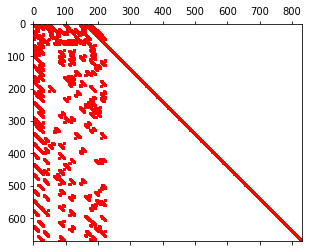

In [2]:
def get_submatrix(offset, Z):
    if offset == -1: return np.zeros((Z, Z), dtype = bool)
    offset %= Z
    if offset == 0: return np.eye(Z, dtype = bool)
    return sp.diags([np.ones(offset), np.ones(Z - offset)],
                    [offset - Z, offset], dtype = bool).toarray()

Z = 16
filler = np.vectorize(get_submatrix, otypes = [np.ndarray], signature = '()->(n,n)', excluded = (1,))
matrix = np.loadtxt('matrices/R1-1711982_BG2_set2.csv', dtype = int)
H = np.block([[x for x in row] for row in filler(matrix, Z)])


plt.spy(H, markersize = 2, color = 'r')

In [3]:
def my_permutation(B, permut, n1, n2, n3):
    v1 = B.take(n1, axis = 1)
    v2 = B.take(n2, axis = 1)
    index1, index2 = permut[n1], permut[n2]
    permut[n1], permut[n2] = index2, index1
    for i in range(v1.shape[0]):
        B[i][n2] = v1[i]
        B[i][n1] = v2[i]
        
    ones_in_n2 = list(np.where(v1 == 1)[0])
    ones_in_n2.remove(n3)
    for i in ones_in_n2:
        B[:][i] = (B[:][i] + B[:][n3]) % 2

        
def custom_gauss_elimination(H):
    B = np.copy(H)
    completed_indexes = [] 
    drop_indexes = []
    K = B.shape[0]
    N = B.shape[1]
    permut = np.arange(N)
    for k_iter in range(K):
        row = B.take(k_iter, axis = 0)
        if(sum(row) != 0):
            i = 0
            while(row[i] != 1):
                i+=1
            my_permutation(B, permut, i, N - K + k_iter, k_iter)
            completed_indexes.append(N - K + k_iter)
        else:
            drop_indexes.append(k_iter)
            
    if not drop_indexes: 
        return B, permut
    else:
        i = 0
        for drop in drop_indexes:
            H = np.delete(H, drop - i, axis=0)
            i+=1
        print("try again...")
        custom_gauss_elimination(H)
        
        
def H2G(H):
    B, permut = custom_gauss_elimination(H)
    assert B[:, -B.shape[0]:].all() == np.eye(B.shape[0], dtype = int).all()

    M = np.shape(H)[0] # N-K
    N = np.shape(H)[1] 
    K = N - M
    G = np.concatenate([np.eye(K), ((-1)*B[:, :K].T %2)], axis=1).astype(bool)
    
    A = np.copy(H)
    for j in range(H.shape[1]):
        h = H.take(permut[j], axis = 1)
        A[:, j] = h[:]
            
    assert (G @ A.T % 2).all() == np.zeros((K, K)).all()
    return G, A

In [4]:
G, A = H2G(H)

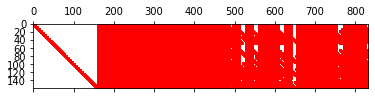

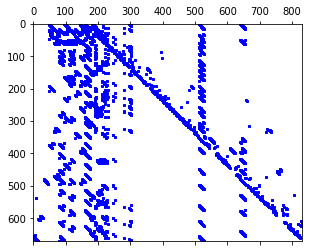

In [6]:
plt.spy(G, markersize = 2, color = 'r')
plt.show()
plt.spy(A, markersize = 2, color = 'b')
plt.show()

In [10]:
max(np.sum(H, axis = 0)

23